# Value at Risk and Expected Shortfall
__Project Objectives:__
- Compute VaR and CVaR using the Historical, Parametric, and Monte Carlo approaches.

In [1]:
# package imports
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm 
from scipy.stats import norm, t
import os

## 1. User-Defined Model Inputs
| Variable | Definition |
|:---|:---|
|tickers_file | (string) A .csv file containing the list of assets to consider as part of portfolio. |
|time | (int) future day for which to calculate VaR/CVaR |
|lookback_days | (int) number of days to consider for historical returns |
|alpha | (int) the confidence level for the (1-alpha)% VaR |
|initial_investment | (float) dollar value invested |
|mc_sims| (int) number of Monte Carlo simulation trials for Monte Carlo VaR approach|
|output_folder | (string) specify an output folder to store results. If folder does not exist, it will be created. |

In [2]:
tickers_file = 'tickers.csv'
time = 100 
lookback_days = 1000
alpha = 5 
initial_investment = 100000
mc_sims = 100000
output_folder = 'outputs/value-at-risk'

## 2. Helper Functions

In [3]:
def get_data(tickers, start, end):
    '''calculates mean returns and covariance matrix for list of tickers
    args:
        (list) tickers list upon which to construct an efficient portfolio
        (datetime) start date of the lookback period
        (datetime) end date of the lookback period
    return:
        (pd.Series) log returns
        (pd.Series) mean return for each asset
        (pd.DataFrame) pairwise covariance matrix between assets
    '''
    stock_data = yf.download(tickers, start=start, end=end)
    stock_data = stock_data['Adj Close']
    returns = np.log(stock_data).diff()
    mean_returns = returns.mean()
    covariance_matrix = returns.cov()
    return returns, mean_returns, covariance_matrix

def portfolio_performance(weights, mean_returns, covariance_matrix, time):
    '''calculates mean and volatility of the portfolio
    args:
        (np.array) list of weights corresponding to each asset
        (pd.Series) mean returns for each asset
        (pd.DataFrame) pairwise covariance matrix between assets
    return:
        (pd.Series) log returns
        (pd.Series) mean return for each ticker
        (pd.DataFrame) covariance matrix
    '''
    returns = np.sum(mean_returns*weights)*time
    std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))*np.sqrt(time)
    return returns, std

## 2.1 Historical VaR

In [4]:
def historical_VaR(returns, alpha=5):
    '''calculates historical value-at-risk
    args:
        (pd.DataFrame or pd.Series) returns
        (optional, int) alpha-level of the distribution

    return:
        (float) percentile of the distribution at the given alpha confidence level, ie VaR
    '''
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historical_VaR, alpha=alpha)
    else:
        raise TypeError('Expected returns to be dataframe or series')

def historical_CVaR(returns, alpha=5):
    '''calculates historical conditional value-at-risk
    args:
        (pd.DataFrame or pd.Series) returns
        (optional, int) alpha-level of the distribution

    return:
        (float) mean of the distribution below the given alpha confidence level, ie CVaR/Expected Shortfall
    '''
    if isinstance(returns, pd.Series):
        below_VaR = returns <= historical_VaR(returns, alpha=alpha)
        return returns[below_VaR].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historical_CVaR, alpha=alpha)
    else:
        raise TypeError('Expected returns to be dataframe or series')

## 2.2 Parametric VaR

In [5]:
def parametric_VaR(portfolio_returns, portfolio_std, distribution = 'normal', alpha = 5, degrees_of_freedom = 6):
    '''calculates parametric portfolio VaR given a distribution with known parameters
    args:
        (float) portfolio returns
        (float) portfolio volatility
        (optional, string) whether to consider a normal distribution or a t-distribution 
        (optional, int) alpha-level of the distribution
        (optional, int) degrees of freedom for the t-distribution
    return:
        (float) portfolio VaR at the given alpha-level
    '''
    if distribution == 'normal':
        VaR = -norm.ppf(alpha/100)*portfolio_std - portfolio_returns
    elif distribution == 't-distribution': 
        nu = degrees_of_freedom
        VaR = np.sqrt((nu-2)/nu)*(-t.ppf(alpha/100,nu))*portfolio_std - portfolio_returns
    else:
        raise TypeError('Expected distribution to be "normal" or "t-distribution"')
    return VaR

def parametric_CVaR(portfolio_returns, portfolio_std, distribution = 'normal', alpha = 5, degrees_of_freedom = 6):
    '''calculates parametric portfolio CVaR given a distribution with known parameters
    args:
        (float) portfolio returns
        (float) portfolio volatility
        (optional, string) whether to consider a normal distribution or a t-distribution 
        (optional, int) alpha-level of the distribution
        (optional, int) degrees of freedom for the t-distribution
    return:
        (float) portfolio CVaR at the given alpha-level
    '''
    if distribution == 'normal':
        CVaR = (alpha/100)**-1*norm.pdf(norm.ppf(alpha/100))*portfolio_std - portfolio_returns
    elif distribution == 't-distribution': 
        nu = degrees_of_freedom
        x_anu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100)*(1-nu)**-1*(nu-2+x_anu**2)*t.pdf(x_anu, nu)*portfolio_std - portfolio_returns
    else:
        raise TypeError('Expected distribution to be "normal" or "t-distribution"')
    return CVaR

## 2.3 Monte Carlo VaR

In [6]:
def simulate_portfolio(weights, n_plots = 100):
    '''Monte Carlo simulation of portfolio returns
    args:
        (np.array) array of weights for the portfolio
        (optional, int) if > 0: plot n_plots realizations of the simulation; elif 0: do not output a plot for the simulations 
    return:
        (pd.Series) the realizations of the Monte Carlo simulation of the portfolio
    '''
    mean_mat = np.full(shape=(time, len(weights)), fill_value=mean_returns).T
    portfolio_sims = np.full(shape=(time, mc_sims), fill_value=0.0)
    for m in tqdm(range(mc_sims)):
        Z = np.random.normal(size=(time, len(weights)))
        L = np.linalg.cholesky(covariance_matrix)
        daily_returns = mean_mat + np.inner(L, Z)
        portfolio_sims[:,m] = np.cumprod(np.inner(weights, 1+daily_returns.T))*initial_investment

    if n_plots > 0:
        plt.plot(portfolio_sims[:,::int(mc_sims/n_plots)])
        plt.ylabel('Portfolio Value ($)')
        plt.xlabel('Days')
        plt.title('MC simulation of stock portfolio')
        plt.show()
        
    return pd.Series(portfolio_sims[-1,:])

def mc_VaR(returns, alpha=5):
    '''calculates value-at-risk using the Monte Carlo simulations
    args:
        (pd.Series) returns
        (optional, int) alpha-level of the distribution

    return:
        (float) percentile of the distribution at the given alpha confidence level, ie VaR
    '''
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError('Expected a pandas data series.')

def mc_CVaR(returns, alpha=5):
    '''calculates conditional value-at-risk using the Monte Carlo simulations
    args:
        (pd.Series) returns
        (optional, int) alpha-level of the distribution

    return:
        (float) mean of the distribution below the given alpha confidence level, ie CVaR/Expected Shortfall
    '''
    if isinstance(returns, pd.Series):
        below_VaR = returns <= mc_VaR(returns, alpha=alpha)
        return returns[below_VaR].mean()
    else:
        raise TypeError('Expected a pandas data series.')

## 3. Execute Model

[*********************100%%**********************]  60 of 60 completed


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3470.09it/s]


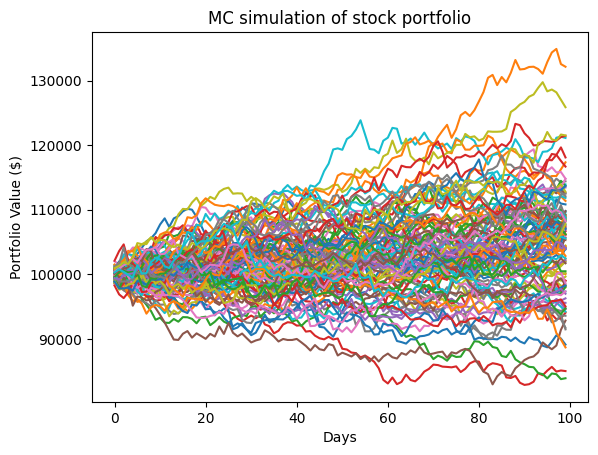

In [7]:
# read in tickers file and create a list of tickers 
missing_values = ["", "#N/A", "NULL", "N/A"]
ticker_df = pd.read_csv(tickers_file, na_values=missing_values, keep_default_na=False)
tickers = list(ticker_df.ticker + '.' + ticker_df.exchange)
# if tickers file makes expected returns available, will use those in place of historical returns
expected_returns = pd.Series(ticker_df.expected_returns)
expected_returns.index = tickers  
# define the start and end dates for the lookback period
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=lookback_days) 
# fetch the data using yfinance and populate global variables   
returns, mean_returns, covariance_matrix = get_data(tickers, start=start_date, end=end_date)
returns = returns.dropna()
mean_returns = mean_returns.where(expected_returns.isna(), expected_returns) # replaces mean_returns with estimate where available, otherwise uses historical data
# random portfolio weights
weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)
returns['portfolio'] = returns.dot(weights)
portfolio_returns, portfolio_std = portfolio_performance(weights, mean_returns, covariance_matrix, time)

hist_VaR = -historical_VaR(returns['portfolio'], alpha=alpha)*np.sqrt(time)
hist_CVaR = -historical_CVaR(returns['portfolio'], alpha=alpha)*np.sqrt(time)

normVaR = parametric_VaR(portfolio_returns, portfolio_std)
normCVaR = parametric_CVaR(portfolio_returns, portfolio_std)

tVaR = parametric_VaR(portfolio_returns, portfolio_std, distribution='t-distribution')
tCVaR = parametric_CVaR(portfolio_returns, portfolio_std, distribution='t-distribution')

portfolio_results = simulate_portfolio(weights)
mcVaR = initial_investment - mc_VaR(portfolio_results, alpha)
mcCVaR = initial_investment - mc_CVaR(portfolio_results, alpha)

## 4. Outputs

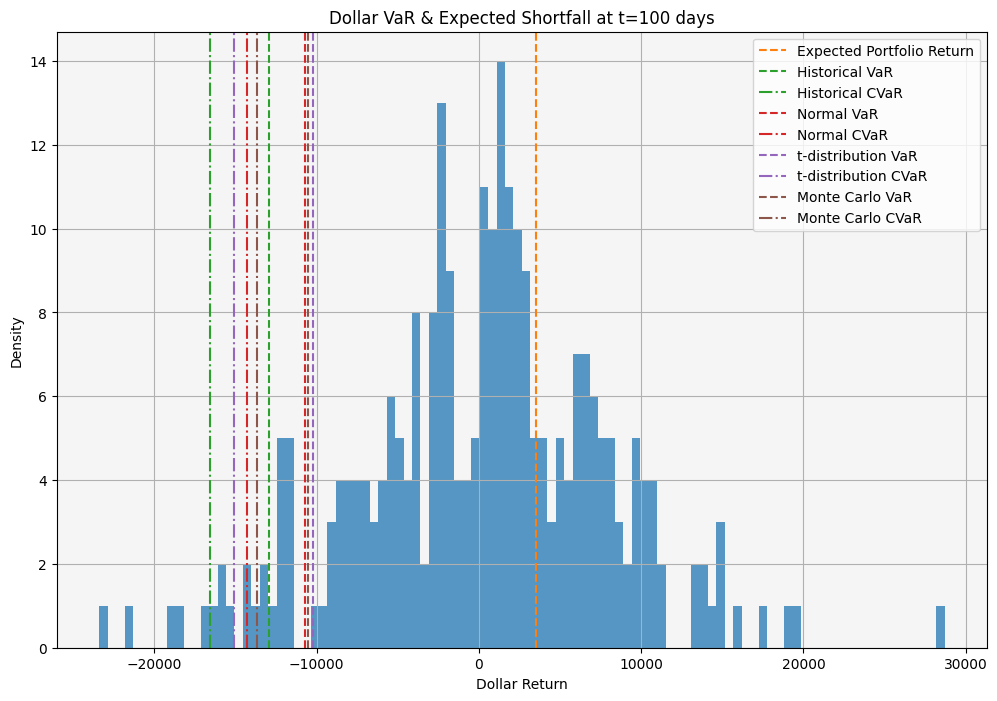

In [8]:
# makes an output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

plt.figure(figsize=(12, 8))
plt.hist(initial_investment*returns['portfolio']*np.sqrt(time), alpha=0.75, bins=100)
plt.axvline(round(initial_investment*portfolio_returns,2), linestyle='--', color='tab:orange', label='Expected Portfolio Return')

plt.axvline(-round(initial_investment*hist_VaR,2), linestyle='--', color='tab:green', label='Historical VaR')
plt.axvline(-round(initial_investment*hist_CVaR,2), linestyle='-.', color='tab:green', label='Historical CVaR')

plt.axvline(-round(initial_investment*normVaR,2), linestyle='--', color='tab:red', label='Normal VaR')
plt.axvline(-round(initial_investment*normCVaR,2), linestyle='-.', color='tab:red', label='Normal CVaR')

plt.axvline(-round(initial_investment*tVaR,2), linestyle='--', color='tab:purple', label='t-distribution VaR')
plt.axvline(-round(initial_investment*tCVaR,2), linestyle='-.', color='tab:purple', label='t-distribution CVaR')

plt.axvline(-round(mcVaR,2), linestyle='--', color='tab:brown', label='Monte Carlo VaR')
plt.axvline(-round(mcCVaR,2), linestyle='-.', color='tab:brown', label='Monte Carlo CVaR')

plt.title(f'Dollar VaR & Expected Shortfall at t={time} days')
plt.xlabel('Dollar Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('grey')
plt.gca().patch.set_alpha(0.075)
save_path = os.path.join(output_folder, 'value_at_risk.png')
plt.savefig(save_path) 
plt.show()

In [9]:
var_results_df = pd.DataFrame({f'Results at the {100-alpha}th CI:':[round(initial_investment*portfolio_returns,2),
                                                                    round(initial_investment*hist_VaR,2), 
                                                                    round(initial_investment*hist_CVaR,2), 
                                                                    round(initial_investment*normVaR,2), 
                                                                    round(initial_investment*normCVaR,2), 
                                                                    round(initial_investment*tVaR,2), 
                                                                    round(initial_investment*tCVaR,2), 
                                                                    round(mcVaR,2), 
                                                                    round(mcCVaR,2)]}, 
                              index=['Expected Portfolio Return', 'Historical VaR', 'Historical CVaR', 'Normal VaR', 'Normal CVaR', 't-distribution VaR', 't-distribution CVaR', 'Monte Carlo VaR', 'Monte Carlo CVaR'])
var_results_df.to_csv('./'+output_folder+'/var_results.csv')
display(var_results_df)

,Results at the 95th CI:
Expected Portfolio Return,3508.47
Historical VaR,12928.11
Historical CVaR,16537.97
Normal VaR,10697.59
Normal CVaR,14306.50
t-distribution VaR,10194.47
t-distribution CVaR,15113.62
Monte Carlo VaR,10544.50
Monte Carlo CVaR,13645.33


## 5. Future Improvements
| Todo | Description |
|:---|:---|
|Generalize multi-variate normal | Current implementation of Monte Carlo assumes multi-variate normal distribution for returns and covariances.  |
|Generalize normal and t-distribution | Current implementation of parametric VaR/CVaR are limited to just normal and t-distributions. |
|Overlay distributions | To get a better sense of which distribution fits the historical data best, overlay other distributions. |
|User-defined weights| Current implementation uses random weights for illustration. Can use tickers.csv to use the allocation of the current portfolio.|